In [43]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint, uniform

In [44]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')                                                         #using keras to import classifier using resnet50 but we can use any pretrained model and plus trained on imagenet so no need to train again

In [45]:
def load_image(img_path):                                           #loading image #udacity source from DLND basically making 
    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img)                                  #necessary for CNN converting images to array of integera
    true_label = img_path.split('/')[-1].split('_')[0]             #basic formatting trial and error se correct string aayega
    return img, true_label                                            #return image aur uska label

In [46]:
#aligning the image using matplotlib documentation mein sab hai read documentation for this
def visualize_classification(class_names, probs, image, true_class=-1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.sca(ax1)
    
    ax1.imshow(image.astype('uint8'))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Image')
    
    y_pos = np.arange(len(class_names))
    barlist = ax2.bar(y_pos, probs, align='center', alpha=0.5)
    if true_class >= 0 and true_class <= 4:
        barlist[true_class].set_color('g')
    ax2.set_xticks(y_pos, minor=False)
    ax2.set_xticklabels(class_names, minor=False, rotation='vertical')
    ax2.set_ylabel('Probability of given class')
    ax2.set_title('Classification')
   
    for bar in barlist:
        v = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., 1.02*v, '%.2f' % v, ha='center')

In [47]:
#using Resnet to lassify images that are to be tested decode_pred and model.prede\ict are built in functions for the classifiers.
def classify_images(images_arr, true_label, visualize=False):
    images = preprocess_input(np.stack(images_arr,axis=0))
    predictions = decode_predictions(model.predict(images),top=5)
    labels, class_names, probs = [], [], []
    for p in predictions:
        labels.append([i[0] for i in p])
        class_names.append([i[1] for i in p])
        probs.append([i[2] for i in p])
    
    if visualize:
        label_index = labels[0].index(true_label) if true_label in labels[0] else -1
        visualize_classification(class_names[0], probs[0], images_arr[0], label_index)
    
    return labels, class_names, probs

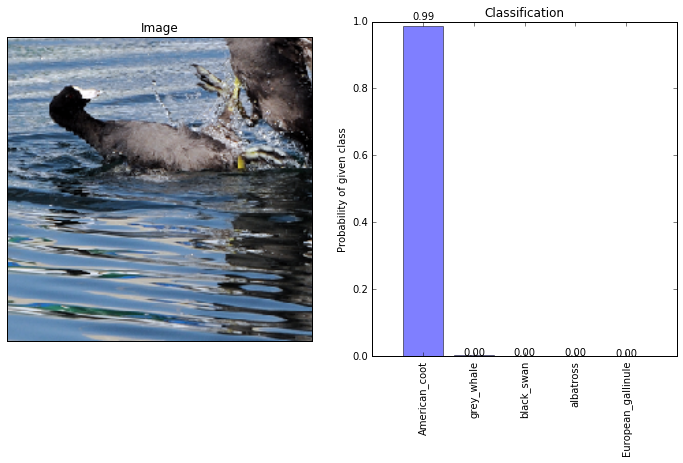

In [48]:

img_clean, true_label = load_image(r'C:\Users\dell15\testicapstony\duckreal.png') #loading the original image ie before the attck has been made
_ = classify_images([img_clean], true_label, visualize=True)

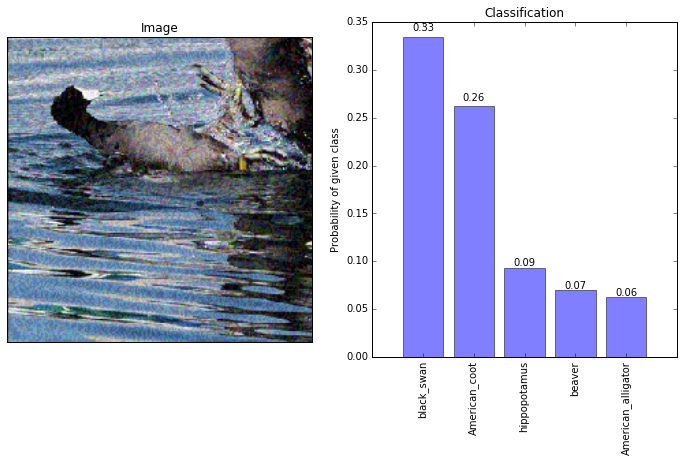

In [49]:
img_adversary, true_label = load_image(r'C:\Users\dell15\testicapstony\duck2.png')
#loading the image which has been attacked by FGSM or targeted adversarial attack in this case I've uploaded FGSM test with targeted to see diff results 
_ = classify_images([img_adversary], true_label, visualize=True)

Probability of the true class being **coot** remains is 98% which is very high. 


In [36]:
# More deflections on adversarial image ie if we increase the pixels deflected it gives better results last time it was 500 if we try with 2000 the accuracy increases significantly 
#img_deflected_more = randomize_pixels(img_adversary, deflections=2000, window=10)
#_ = classify_images([img_deflected_more], true_label, visualize=True)

In [37]:
# More deflections on clean image check to see and change values 
#img_clean_deflected_more = randomize_pixels(img_clean, deflections=200, window=10)
#_ = classify_images([img_clean_deflected_more], true_label, visualize=True)

# Implementing wavelet denoising in scikit learn to see how it may affect results

In [50]:
#check documentantion pretty good examples isme image is /255 to normalize pixel values
# plz refer to this link if you want to make changes but mere hisaab se this is the best feel free to check it out
#http://scikit-image.org/docs/dev/api/skimage.restoration.html
from skimage.restoration import denoise_wavelet
def denoiser(img):
    return denoise_wavelet(img/255.0, sigma=0.04, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0

yahaan ive only implemented wavelet denoising as it gave me the best result there are many types of image denoising
denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, denoise_nl_means, wiener that are prebuilt so test on all these jiss ki you know why wavelet is better and others arent to use them just chage ;ibrary name or any confusion documentation check karo usme bahut ache se explained hai

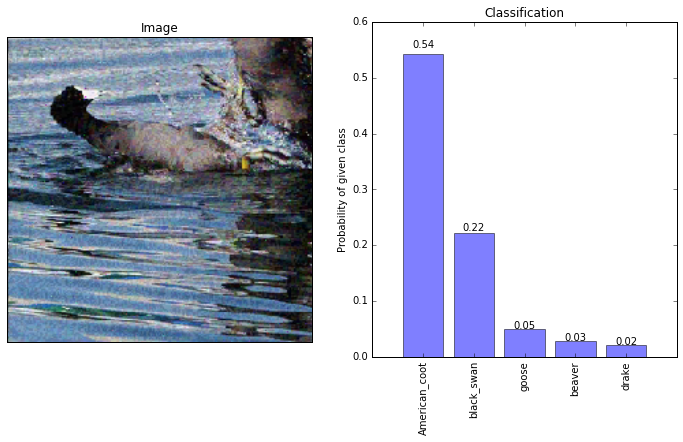

In [51]:
img_deflected_denoised = denoiser(img_deflected)
_ = classify_images([img_deflected_denoised], true_label, visualize=True)

Further we can improve our accuracy by implemtenting R-CAMS
http://cnnlocalization.csail.mit.edu/
    using these maps on top of adversarial images give us a better classification accuracy 

C:\Users\dell15\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


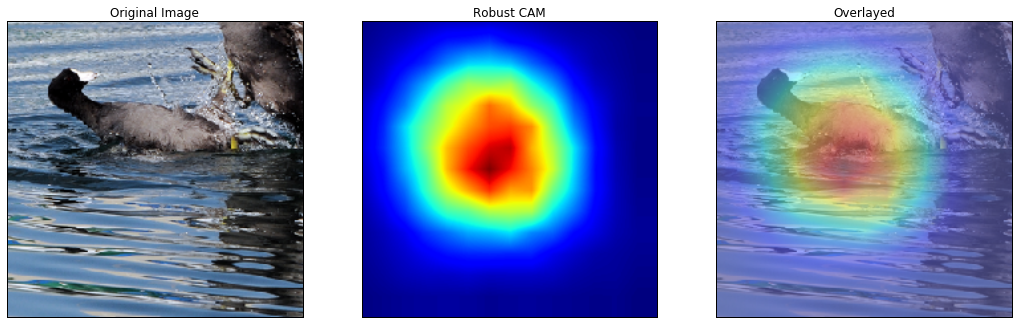

In [52]:
from scipy.misc import imread
from matplotlib.colors import Normalize

# We normalize the map, because rcam_prob is treated
# as probability values
rcam_prob = Normalize()(imread('maps/n02447366_00008562.png'))

f, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].imshow(img_clean.astype('uint8'))
ax[0].set_title('Original Image')
ax[1].imshow(rcam_prob)
ax[1].set_title('Robust CAM')
ax[2].imshow(rcam_prob, cmap='jet', alpha=0.6)
ax[2].imshow(img_clean.astype('uint8'), alpha=0.4)
ax[2].set_title('Overlayed')
for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])


map is downloaded from the link mentioned above and saved 3 types of maps were tested ie which had their symmetary in the middle,left side and right side, Robust cam was the best out of 3

In [53]:
def randomize_deflection_with_overlay(img, rcam_prob, deflections, window):
    img = np.copy(img)
    H, W, C = img.shape
    while deflections > 0:
        
        for c in range(C):
            x,y = randint(0,H-1), randint(0,W-1)
            
            if uniform(0,1) < rcam_prob[x,y]:
                continue
                
            while True: 
                a,b = randint(-1*window,window), randint(-1*window,window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            img[x,y,c] = img[x+a,y+b,c] 
        deflections -= 1
    return img

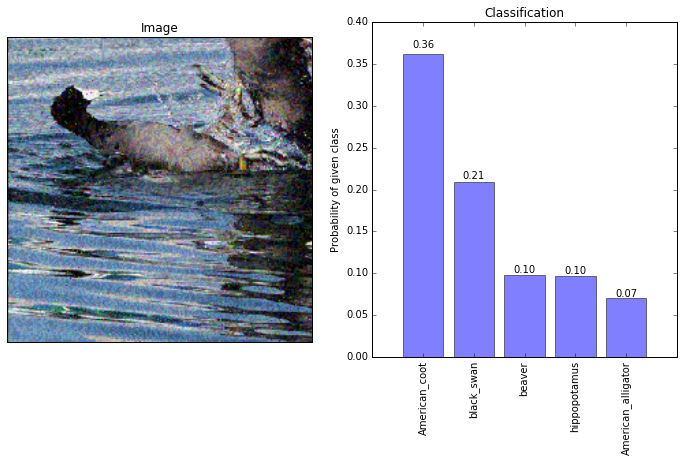

In [54]:
img_deflected_rcam = randomize_deflection_with_overlay(img_adversary, rcam_prob, deflections=4000, window=15)
_ = classify_images([img_deflected_rcam], true_label, visualize=True)

# As we can see accuracy has imcreaased by  5% as compared to denoising the wavelet 